# Домашнее задание 6 - временные ряды

__Оценки-баллы__: 
- 1: 1
- 2: 2
- 3: 3-4
- 4: 5-6
- 5: 7-9
- 6: 10-12
- 7: 13-14
- 8: 15-16
- 9: 17
- 10: 18-30

__DL (срок сдачи ДЗ)__: 22.12.2021 22:00. После этого срока работы НЕ будут приниматься

__Формат сдачи - в личный аккаунт telegram: @zhuikov_vv__: hw12_14_ivanov_i_i.ipynb

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

import pmdarima as pm
from pmdarima import model_selection

# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Стиль для графиков
plt.style.use('ggplot')
%matplotlib inline

data = sm.datasets.macrodata.load_pandas().data

Вам представлены квартальные макроэкономические данные США. В датасете представлен ВВП, его компоненты (совокупный доход, потребление и инвестиции), а также прочие показатели. Задача - спрогнозировать ВВП Америки на 8 кварталов вперёд. Метрика - MAPE. Все гипотезы тестируются на уровне значимости 5%

In [2]:
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


- **year**      - 1959q1 - 2009q3
- **quarter**   - 1-4
- **realgdp**   - Real gross domestic product (Bil. of chained 2005 US\$, seasonally adjusted annual rate)
- **realcons**  - Real personal consumption expenditures (Bil. of chained 2005 US\$, seasonally adjusted annual rate)
- **realinv**   - Real gross private domestic investment (Bil. of chained 2005 US\$, seasonally adjusted annual rate)
- **realgovt**  - Real federal consumption expenditures & gross investment (Bil. of chained 2005 US\$, seasonally adjusted annual rate)
- **realdpi**   - Real private disposable income (Bil. of chained 2005 US\$, seasonally adjusted annual rate)
- **cpi**       - End of the quarter consumer price index for all urban consumers: all items (1982-84 = 100, seasonally adjusted).
- **m1**        - End of the quarter M1 nominal money stock (Seasonally adjusted)
- **tbilrate**  - Quarterly monthly average of the monthly 3-month treasury bill: secondary market rate
- **unemp**     - Seasonally adjusted unemployment rate (\%)
- **pop**       - End of the quarter total population: all ages incl. armed forces over seas
- **infl**      - Inflation rate (ln(cpi_{t}/cpi_{t-1}) * 400)
- **realint**   - Real interest rate (tbilrate - infl)

### Задание 1 [5]

Приведите в порядок переменную, отвечающую за время и преобразуйте её в формат pandas datetime с квартальной периодичностью. Визуализируйте ряд ВВП. Какие характерные паттерны вы наблюдаете?

In [3]:
data['enddate'] = pd.PeriodIndex(year=data['year'], quarter=data['quarter'], freq="Q").to_timestamp(how='end')
data.head(4)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,enddate
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,1959-03-31 23:59:59.999999999
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,1959-06-30 23:59:59.999999999
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,1959-09-30 23:59:59.999999999
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,1959-12-31 23:59:59.999999999


In [4]:
data = data.set_index('enddate')

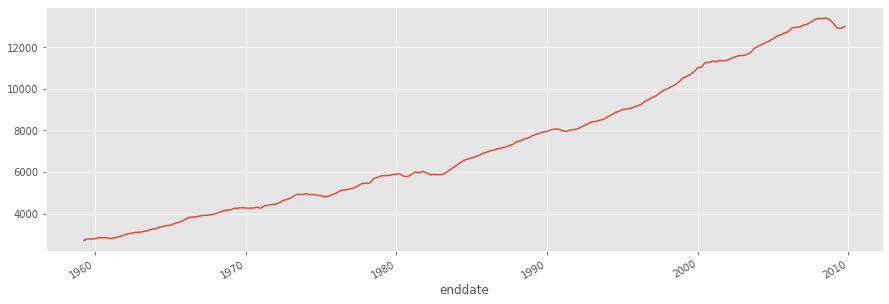

In [5]:
data['realgdp'].plot(figsize = (15, 5));

 На графике виден явный восходящий тренд.

In [6]:
data_columns = ['realgdp']

gdp_year_mean = data[data_columns].resample('Y').mean()
gdp_year_rolling = data[data_columns].rolling(4, center=True).mean()

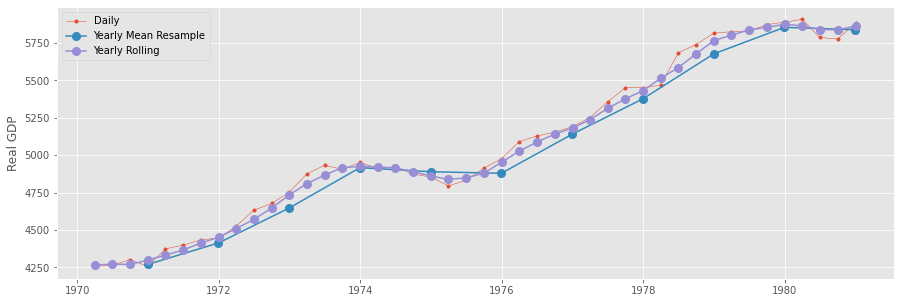

In [7]:
start, end = '1970', '1980'

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data.loc[start:end, 'realgdp'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(gdp_year_mean.loc[start:end, 'realgdp'],
marker='o', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.plot(gdp_year_rolling.loc[start:end, 'realgdp'],
marker='o', markersize=8, linestyle='-', label='Yearly Rolling')
ax.set_ylabel('Real GDP')
ax.legend();

Построим скользящее среднее для 10 лет.

In [8]:
gdp_10year_rolling = data[data_columns].rolling(window=4*10, center=True).mean()

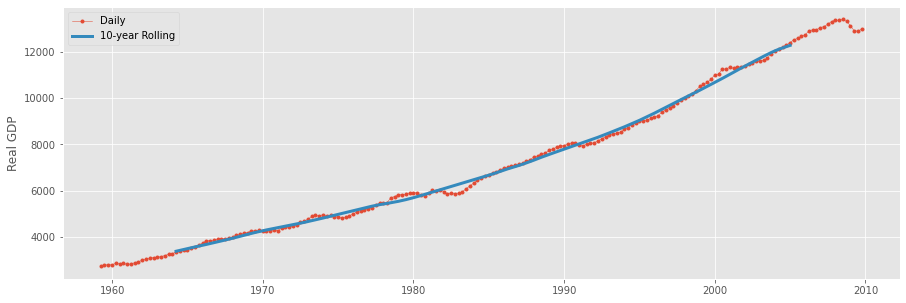

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data['realgdp'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(gdp_10year_rolling['realgdp'], linestyle='-', linewidth=3, label='10-year Rolling')
ax.set_ylabel('Real GDP')
ax.legend();

Виден почти линейный восходящий тренд.

### Задание 2 [15]

Определите порядок интеграции ряда ВВП с помощью формальных тестов. В случае противоречий ADF и KPSS-теста, полагайтесь на KPSS-тест. Постройте наивную модель и посчитайте метрику MAPE.

In [10]:
import warnings 
warnings.filterwarnings('ignore')

y = data['realgdp']

In [11]:
adfuller(y, regression='ct', autolag='AIC')

(-1.2317718968009244,
 0.9037875818651024,
 12,
 190,
 {'1%': -4.00722493293483,
  '5%': -3.43385428838023,
  '10%': -3.1407704096807114},
 2034.0982863559145)

Тестовая статистика больше критического значения, значит ряд нестационарный.

In [12]:
kpss(y, regression='ct')

(0.3275225712886681,
 0.01,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

Тестовая статистика больше критического значения, значит ряд нестационарный.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

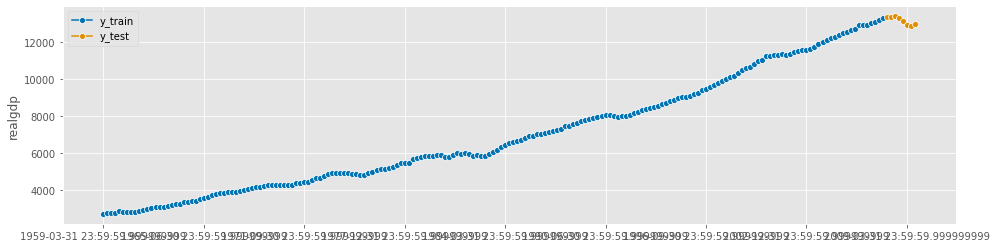

In [13]:
y.index.freq = 'Q'

y_train, y_test = temporal_train_test_split(y, test_size = 8)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [14]:
fh = ForecastingHorizon(y_test.index, is_relative = False)
fh

ForecastingHorizon(['2007-12-31 23:59:59.999999999',
               '2008-03-31 23:59:59.999999999',
               '2008-06-30 23:59:59.999999999',
               '2008-09-30 23:59:59.999999999',
               '2008-12-31 23:59:59.999999999',
               '2009-03-31 23:59:59.999999999',
               '2009-06-30 23:59:59.999999999',
               '2009-09-30 23:59:59.999999999'],
              dtype='datetime64[ns]', freq='Q-DEC', is_relative=False)

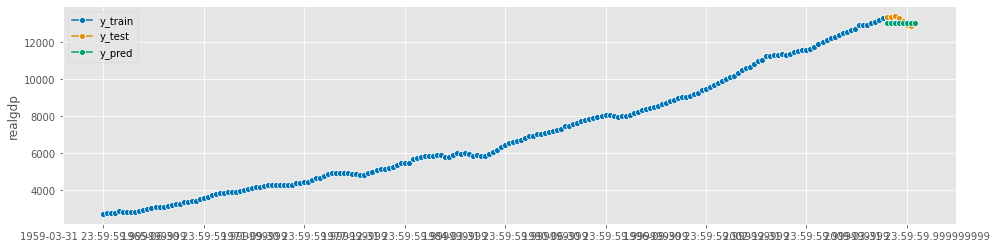

In [15]:
forecaster = NaiveForecaster(strategy="mean", window_length=8)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [16]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE = " + str(mape(y_pred, y_test)))

MAPE = 1.6810480658074258


### Задание 3 [10]*

Для ряда ВВП подберите оптимальную ARIMA-модель и посчитайте метрику MAPE

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='realgdp'>)

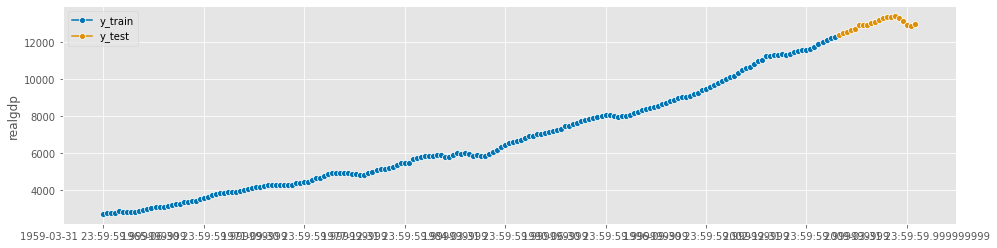

In [17]:
y_train, y_test = temporal_train_test_split(y, test_size=4*5)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [18]:
arima_model_y = pm.auto_arima(
    y_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    seasonal=True, m = 7,
    start_P=0, start_Q=0,
    max_P = 2, max_Q = 2,
    max_D=2, max_d=2,
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
)

 ARIMA(0,2,0)(0,0,0)[7]             : BIC=2015.321, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[7]             : BIC=2020.520, Time=0.14 sec
 ARIMA(0,2,0)(0,0,2)[7]             : BIC=2025.699, Time=0.21 sec
 ARIMA(0,2,0)(1,0,0)[7]             : BIC=2020.521, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[7]             : BIC=2025.352, Time=0.22 sec
 ARIMA(0,2,0)(1,0,2)[7]             : BIC=2028.246, Time=0.33 sec
 ARIMA(0,2,0)(2,0,0)[7]             : BIC=2025.698, Time=0.11 sec
 ARIMA(0,2,0)(2,0,1)[7]             : BIC=2028.456, Time=0.31 sec
 ARIMA(0,2,0)(2,0,2)[7]             : BIC=inf, Time=0.58 sec
 ARIMA(0,2,1)(0,0,0)[7]             : BIC=1952.539, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : BIC=1955.190, Time=0.12 sec
 ARIMA(0,2,1)(0,0,2)[7]             : BIC=1959.186, Time=0.24 sec
 ARIMA(0,2,1)(1,0,0)[7]             : BIC=1955.623, Time=0.13 sec
 ARIMA(0,2,1)(1,0,1)[7]             : BIC=1959.258, Time=0.20 sec
 ARIMA(0,2,1)(1,0,2)[7]             : BIC=1964.318, Time=0.36 sec
 ARIMA(0,2,1)(2

In [19]:
arima_model_y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -963.604
Date:                Sun, 26 Dec 2021   AIC                           1935.209
Time:                        16:48:13   BIC                           1948.003
Sample:                             0   HQIC                          1940.396
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2258      0.074      3.048      0.002       0.081       0.371
ar.L2          0.2139      0.063      3.416      0.001       0.091       0.337
ma.L1         -0.9746      0.019    -52.679      0.000      -1.011      -0.938
sigma2      2421.1120    200.573     12.071      0.000    2027.996    2814.228
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
y_pred, y_pred_ci = arima_model_y.predict(
    n_periods=4*5, 
    return_conf_int=True, 
    alpha=0.05
)

print("MAPE = " + str(mape(y_pred, y_test)))

MAPE = 1.4896911924122596


In [21]:
data_forecast = pd.DataFrame({'y_pred': y_pred,
                              'ci_lower': y_pred_ci[:,0], 
                              'ci_upper': y_pred_ci[:,1]})
data_forecast.index = fh
data_forecast.head()

,y_pred,ci_lower,ci_upper
2004-12-31 23:59:59.999999999,12383.157144,12286.717331,12479.596957
2005-03-31 23:59:59.999999999,12461.255929,12306.787439,12615.724420
2005-06-30 23:59:59.999999999,12536.852056,12322.085648,12751.618463
2005-09-30 23:59:59.999999999,12611.556901,12341.764524,12881.349278
2005-12-31 23:59:59.999999999,12685.525241,12363.933254,13007.117229


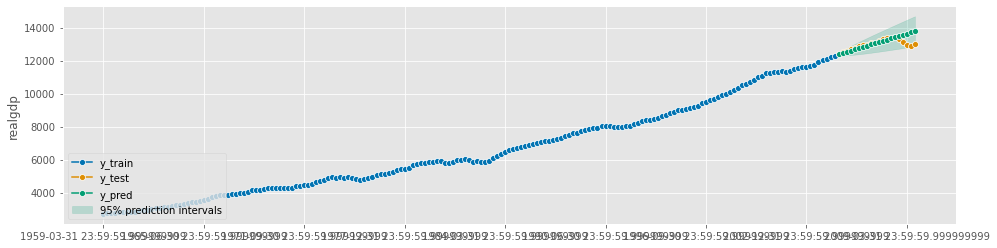

In [22]:
fig, ax = plot_series(y_train,
                      y_test,
                      data_forecast.y_pred,
                      labels=["y_train", "y_test", "y_pred"]
                     );
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    data_forecast["ci_lower"],
    data_forecast["ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');